In [1]:
import importlib
import pandas as pd
import numpy as np

import IdMatcher

importlib.reload(IdMatcher)

from IdMatcher import IdMatcher

MATCHER = IdMatcher("../співставлення ID постів з ID Cams.csv")
df = pd.read_csv("/media/data/osamoile/SRI/all_posts_date.csv")
df

,device_id,phenomenon,value,value_text,date,hour,minute,second
0,4211,pm25,3.84,NaN,2020-07-17,21,31,0
1,4211,pm25,4.12,NaN,2020-07-17,21,28,34
2,4211,pm25,4.40,NaN,2020-07-17,21,33,25
3,4211,pm25,4.76,NaN,2020-07-17,21,21,17
4,4211,pm25,4.87,NaN,2020-07-17,21,38,17
...,...,...,...,...,...,...,...,...
16295446,1041,pm25,5.30,NaN,2020-01-29,14,52,0
16295447,1041,pm25,5.34,NaN,2020-01-29,14,54,25
16295448,1041,pm25,5.48,NaN,2020-01-29,14,59,17
16295449,1041,pm25,5.68,NaN,2020-01-29,15,1,42


In [2]:
# Координати наземних станцій SaveEcoBot
COORD = pd.read_csv("../saveecobot-kyiv-stations-coordinates.csv")
COORD

,id,x,y
0,28,50.444000,30.540000
1,30,50.434000,30.432000
2,43,50.411719,30.618949
3,47,50.472938,30.508250
4,108,50.362592,30.442744
...,...,...,...
208,13802,50.493513,30.506244
209,13803,50.437397,30.595666
210,13811,50.412880,30.607856
211,13820,50.499084,30.577510


In [3]:
# Для пошуку станцій-викидів розділимо станції на групи. Станції в одній групі вважатимемо "сусідніми"
# Метод 1. За пікселем CAMS, у який потрапляє станція

cluster = []
coord_CAMS = COORD.copy()

for i, row in coord_CAMS.iterrows():
    cluster.append(MATCHER.getCamsIdByPostId(row.id))
coord_CAMS['cluster'] = cluster

coord_CAMS

,id,x,y,cluster
0,28,50.444000,30.540000,6563
1,30,50.434000,30.432000,6562
2,43,50.411719,30.618949,6564
3,47,50.472938,30.508250,6378
4,108,50.362592,30.442744,6747
...,...,...,...,...
208,13802,50.493513,30.506244,6378
209,13803,50.437397,30.595666,6564
210,13811,50.412880,30.607856,6564
211,13820,50.499084,30.577510,6379


In [4]:
# Кількість станцій у групі для кожної з 12 груп:
stations_per_cluster = coord_CAMS.groupby(by=coord_CAMS.cluster).id.count().rename('total').reset_index()
stations_per_cluster.rename(columns={'cluster':'Номер пікселя CAMS', 'total':'Кількість станцій у пікселі'})

,Номер пікселя CAMS,Кількість станцій у пікселі
0,6192,1
1,6193,7
2,6194,5
3,6377,16
4,6378,50
5,6379,20
6,6562,6
7,6563,51
8,6564,42
9,6747,2


In [104]:
import plotly.graph_objs as go

def plot_clusters(coord, title):
    data = []
    for group in sorted(coord.cluster.unique()):
        df_group = coord[coord.cluster == group]
        trace = go.Scatter(x=df_group.y, 
                            y=df_group.x,
                            mode='markers',
                            name=str(group))
        data.append(trace)

    layout = go.Layout(title=title, width=800, height=800)
    fig = go.Figure(data=data, layout=layout, layout_yaxis_range=[50.3,50.6], layout_xaxis_range=[30.3,30.7])

    return fig

plot_clusters(coord_CAMS, 'Кластеризація станцій за CAMS пікселями')

In [6]:
# Візьмемо дані з кластеру 6377 (16 станцій)

def df_cluster_num(coord, num):
    return df[df.device_id.isin(coord[coord.cluster == num].id.tolist())]

df_cluster = df_cluster_num(coord_CAMS, 6377)
df_cluster

,device_id,phenomenon,value,value_text,date,hour,minute,second
914344,1437,pm25,43.45,NaN,2019-10-23,21,55,8
914345,1437,pm25,42.58,NaN,2019-10-23,21,59,42
914346,1437,pm25,44.58,NaN,2019-10-23,22,2,16
914347,1437,pm25,45.52,NaN,2019-10-23,22,4,51
914348,1437,pm25,44.32,NaN,2019-10-23,22,7,25
...,...,...,...,...,...,...,...,...
16295446,1041,pm25,5.30,NaN,2020-01-29,14,52,0
16295447,1041,pm25,5.34,NaN,2020-01-29,14,54,25
16295448,1041,pm25,5.48,NaN,2020-01-29,14,59,17
16295449,1041,pm25,5.68,NaN,2020-01-29,15,1,42


In [7]:
# Усереднимо показники кожної станції за часовим інтервалом в 5 хвилин
# Наприклад, середнє значення для станції 902 у проміжку часу 00:00-00:05 дорівнює 14.000,
#                         а для станції 12829 у проміжку часу 23:50-23:55 - 11.820

def median_by_station_and_time_interval(df_area, interval_minutes=5):
    cut = pd.cut(df_area.minute, np.arange(-1, 60, interval_minutes))
    return df_area.groupby([df_area.device_id, df_area.hour, cut]).value.median()

medians = median_by_station_and_time_interval(df_cluster)
medians

device_id  hour  minute  
902        0     (-1, 4]     14.000
                 (4, 9]      16.000
                 (9, 14]     14.250
                 (14, 19]    14.000
                 (19, 24]    14.250
                              ...  
12829      23    (34, 39]    11.630
                 (39, 44]    10.850
                 (44, 49]    11.100
                 (49, 54]    11.820
                 (54, 59]    11.035
Name: value, Length: 3456, dtype: float64

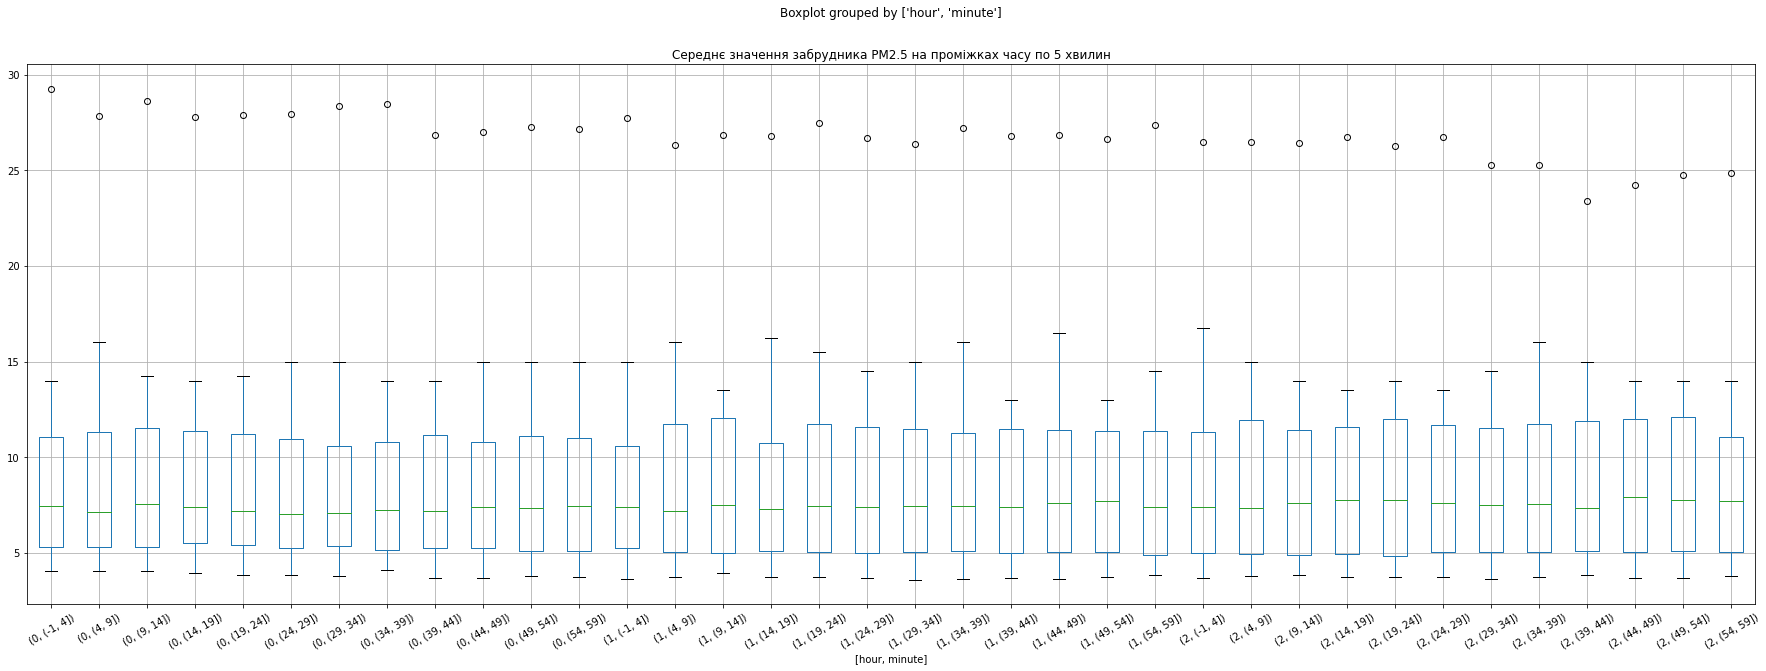

In [12]:
from matplotlib import pyplot as plt

# Побудуємо ящик з вусами для кожного проміжку часу задля пошуку станцій-викидів
# Для простоти візуалізації показаний лише проміжок часу 0:00-3:00
# Бачимо єдиний викид на кожному інтервалі 

def outliers_data_time_interval(df_intervals, hour_from, hour_to):
    data = df_intervals.reset_index()
    return data[(data.hour >= hour_from) & (data.hour < hour_to)]

def boxplot_time_interval(df_intervals, hour_from, hour_to):
    boxplot_data = outliers_data_time_interval(df_intervals, hour_from, hour_to)
    boxplot_data.boxplot(by=['hour', 'minute'], column=['value'], figsize=(30, 10), rot=30)
    plt.title('Середнє значення забрудника PM2.5 на проміжках часу по 5 хвилин')
    plt.show()

boxplot_time_interval(medians, 0, 3)

In [13]:
# Знайдемо цей викид (ту станцію, якій він належить) за допомогою IQR-тесту 
# (pandas.DataFrame.boxplot також використовує його для візуалізації викидів)
# Всі викиди належать єдиній станції (не тільки на проміжку 0:00-3:00, а і протягом цілої доби)

def outliers_time_interval(df_intervals, hour_from, hour_to):
    data = outliers_data_time_interval(df_intervals, hour_from, hour_to)
    q1 = data.groupby(['hour', 'minute']).quantile(0.25).value
    q3 = data.groupby(['hour', 'minute']).quantile(0.75).value
    outlier_top_lim = q3 + 1.5 * (q3 - q1)
    outlier_bottom_lim = q1 - 1.5 * (q3 - q1)
    df_res = pd.DataFrame(columns=data.keys())
    for i, row in data.iterrows():
        if row.value > outlier_top_lim[row.hour][row.minute] or row.value < outlier_bottom_lim[row.hour][row.minute]:
            row['top_lim'] = outlier_top_lim[row.hour][row.minute]
            row['bot_lim'] = outlier_bottom_lim[row.hour][row.minute]
            df_res = df_res.append(row, ignore_index=True)
    return df_res

outliers = outliers_time_interval(medians, 0, 24)
print(outliers.device_id.unique())
outliers

[1072]


,device_id,hour,minute,value,bot_lim,top_lim
0,1072,0,"(-1, 4]",29.26560,-3.40500,19.75500
1,1072,0,"(4, 9]",27.86460,-3.70500,20.29500
2,1072,0,"(9, 14]",28.63930,-4.10875,20.94125
3,1072,0,"(14, 19]",27.79280,-3.33250,20.16750
4,1072,0,"(19, 24]",27.90625,-3.25500,19.84500
...,...,...,...,...,...,...
283,1072,23,"(34, 39]",27.50115,-3.86750,21.09250
284,1072,23,"(39, 44]",28.17860,-2.92750,19.85250
285,1072,23,"(44, 49]",28.20830,-3.54250,20.71750
286,1072,23,"(49, 54]",28.82295,-3.88500,21.15500


In [14]:
# Проведемо цей тест для усіх кластерів

def outliers_for_cluster(i, coord):
    df_cluster = df_cluster_num(coord, i)
    medians = median_by_station_and_time_interval(df_cluster)
    outliers = outliers_time_interval(medians, 0, 24)
    return outliers

def outliers_all_clusters(coord):
    return pd.concat([outliers_for_cluster(i, coord) for i in coord.cluster.unique()], ignore_index=True)

outliers_CAMS = outliers_all_clusters(coord_CAMS)
outliers_CAMS

,device_id,hour,minute,value,bot_lim,top_lim
0,1208,0,"(-1, 4]",17.90,-1.638750,14.731250
1,1208,1,"(-1, 4]",17.90,-1.240000,13.840000
2,1208,2,"(-1, 4]",17.50,-2.246250,14.363750
3,1208,3,"(-1, 4]",17.00,-2.403750,15.366250
4,1208,4,"(-1, 4]",16.90,-2.101250,14.008750
...,...,...,...,...,...,...
4321,3694,22,"(29, 34]",4.82,4.917500,12.057500
4322,3694,22,"(34, 39]",4.84,5.050000,11.370000
4323,3694,22,"(39, 44]",4.76,4.900000,11.700000
4324,3694,22,"(44, 49]",4.94,5.002500,12.142500


In [39]:
# Знайдено 33 станції-викиди 

# print(len(outliers_CAMS.device_id.unique()))
outliers_CAMS.groupby(by=outliers_CAMS.device_id).count()#.reset_index()[['device_id', 'hour']] #.sort_values()

,hour,minute,value,bot_lim,top_lim
device_id,,,,,
1061,99,99,99,99,99
1072,288,288,288,288,288
1208,24,24,24,24,24
1290,10,10,10,10,10
1331,87,87,87,87,87
1394,1,1,1,1,1
1415,177,177,177,177,177
1553,1,1,1,1,1
2792,277,277,277,277,277


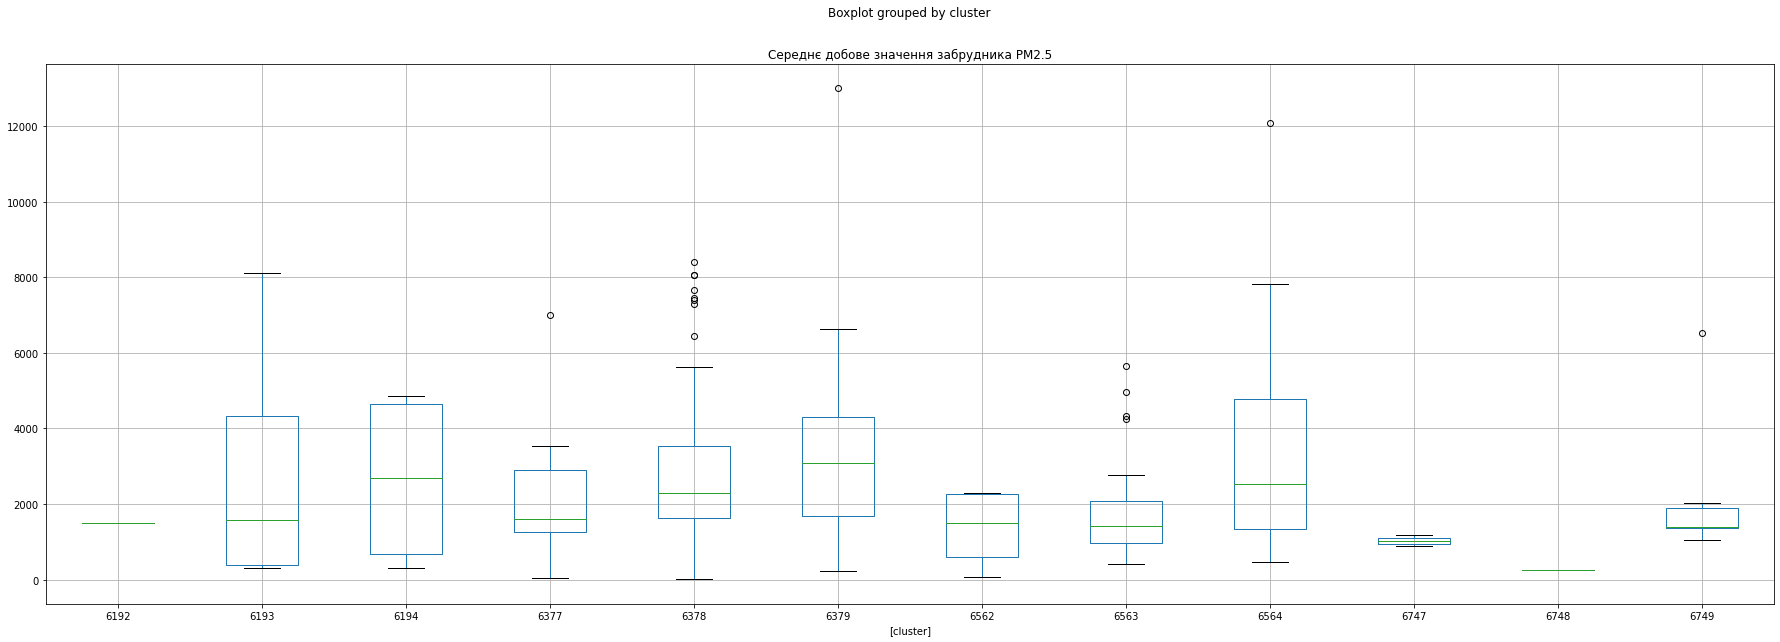

In [109]:
# Деякі станції є викидом лише на одному, чи декількох проміжках часу, чого недостатньо для того,
# щоб ствержувати некоректність показників цих станцій
# Порахуємо середню добову кількість викидів, просумувавши значення на всіх інтервалах, і знову
# побудуємо ящик з вусами 

def daily_sum_for_cluster(i, coord):
    medians = median_by_station_and_time_interval(df_cluster_num(coord, i))
    daily_sum = medians.reset_index().groupby(by='device_id').value.sum().reset_index()
    daily_sum['cluster'] = [i] * len(daily_sum)
    return daily_sum

def daily_sum(coord):
    return pd.concat([daily_sum_for_cluster(i, coord) for i in coord.cluster.unique()], ignore_index=True)

def boxplot_daily(coord):
    boxplot_data = daily_sum(coord)
    boxplot_data.boxplot(by=['cluster'], column=['value'], figsize=(30, 10))
    plt.title('Середнє добове значення забрудника PM2.5')
    plt.show()

boxplot_daily(coord_CAMS)

In [11]:
# Знайдено 16 станцій - викидів

def outliers_daily(coord):
    data = daily_sum(coord)
    q1 = data.groupby(['cluster']).quantile(0.25).value
    q3 = data.groupby(['cluster']).quantile(0.75).value
    outlier_top_lim = q3 + 1.5 * (q3 - q1)
    outlier_bottom_lim = q1 - 1.5 * (q3 - q1)
    df_res = data[0:0]
    for i, row in data.iterrows():
        if row.value > outlier_top_lim[row.cluster] or row.value < outlier_bottom_lim[row.cluster]:
            row['top_lim'] = outlier_top_lim[row.cluster]
            row['bot_lim'] = outlier_bottom_lim[row.cluster]
            df_res = df_res.append(row, ignore_index=True)
    df_res.device_id = df_res.device_id.astype('int32')
    df_res.cluster = df_res.cluster.astype('int32')
    return df_res

outliers_daily_CAMS = outliers_daily(coord_CAMS)
outliers_daily_CAMS

,device_id,value,cluster,bot_lim,top_lim
0,2867,4262.50000,6563,-702.241250,3766.028750
1,2878,4321.26500,6563,-702.241250,3766.028750
2,3514,5665.00000,6563,-702.241250,3766.028750
3,13853,4959.22500,6563,-702.241250,3766.028750
4,1415,12098.46500,6564,-3836.780713,9969.001188
5,3432,7441.99500,6378,-1199.662500,6364.997500
6,13141,8063.01500,6378,-1199.662500,6364.997500
7,13207,7296.28700,6378,-1199.662500,6364.997500
8,13208,7670.24145,6378,-1199.662500,6364.997500
9,13268,8055.74245,6378,-1199.662500,6364.997500


In [105]:
# Метод 2. Кластеризація за допомогою k-means (15 кластерів)
# Застосуємо алгоритм k-means для об'єднання станцій у кластери - це дасть нам можливість використовувати 
# більше ніж 12 кластерів, а також більш точно аналізувати які станції насправді є "сусідніми"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

coord_kmeans = COORD.copy()
kmeans = KMeans(n_clusters=15, init='k-means++', max_iter=500, n_init=10, random_state=0)
clusters = kmeans.fit_predict(coord_kmeans[['x', 'y']])
coord_kmeans['cluster'] = clusters
# plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], s=300, c='red')
plot_clusters(coord_kmeans, 'Кластеризація станцій за розташуванням методом k-means')

In [21]:
# Пошук викидів для кластерів отриманих за допомогою k-means

outliers_kmeans = outliers_all_clusters(coord_kmeans)
print(len(outliers_kmeans.device_id.unique()))
outliers_kmeans.groupby(by=outliers_kmeans.device_id).device_id.count().sort_values()

49


device_id
13811      1
968        1
13455      1
1083       1
13368      1
3653       1
3652       1
1394       1
13820      1
3492       1
3112       1
3600       2
13422      2
3111       2
3018       2
47         3
2827       3
3621       5
2762      13
902       14
1290      19
13673     24
1208      24
3622      28
1061      35
3231      37
3620      73
1331      75
3504      96
3619      98
13789    108
3432     118
3682     120
13207    130
2867     152
13802    168
13141    169
13268    171
3688     176
13759    197
3514     203
3603     206
1415     209
2878     244
13703    248
13853    256
13208    271
1072     286
2792     288
Name: device_id, dtype: int64

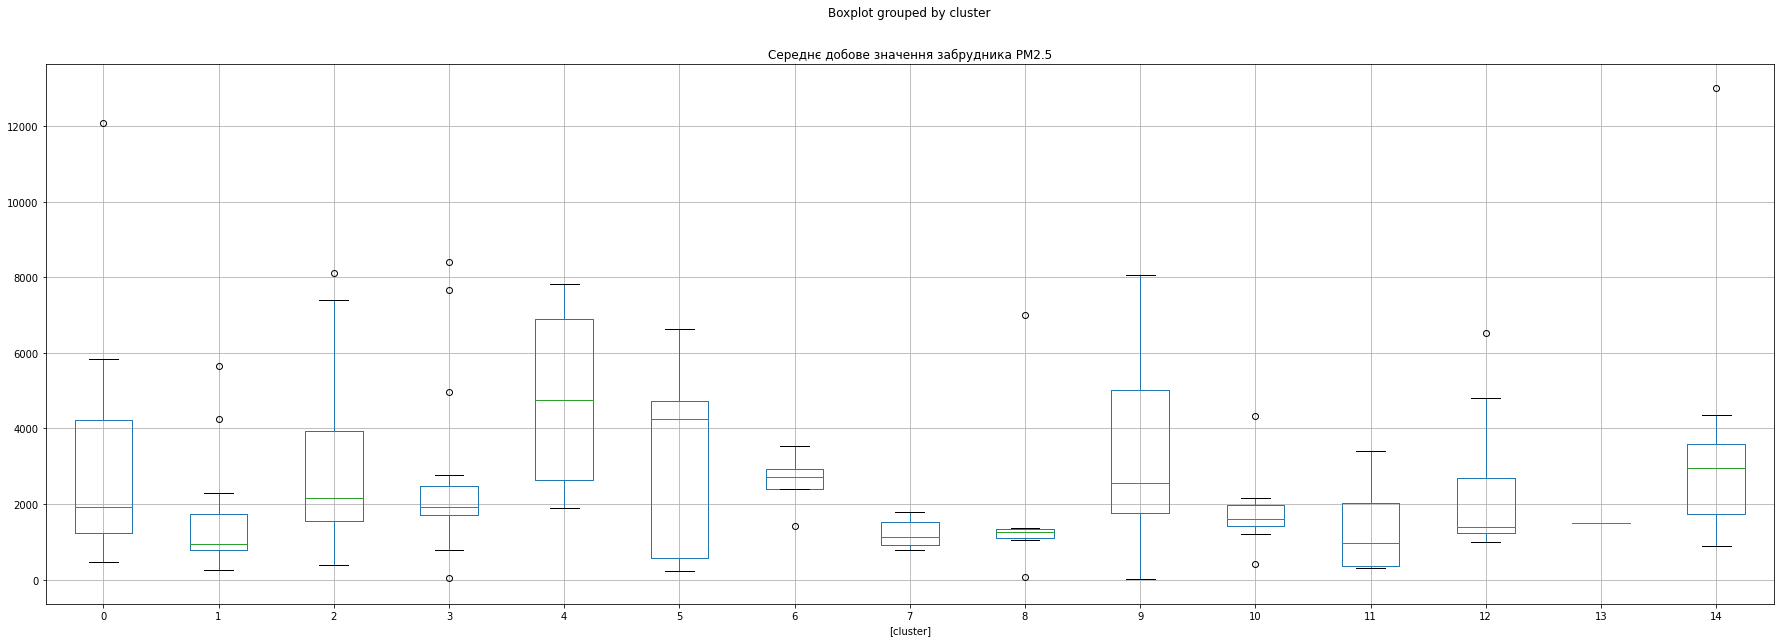

In [110]:
boxplot_daily(coord_kmeans)

In [23]:
outliers_daily_kmeans = outliers_daily(coord_kmeans)
outliers_daily_kmeans

,device_id,value,cluster,bot_lim,top_lim
0,1041,32.49500,3,535.572500,3635.842500
1,13208,7670.24145,3,535.572500,3635.842500
2,13703,8415.59300,3,535.572500,3635.842500
3,13853,4959.22500,3,535.572500,3635.842500
4,1415,12098.46500,0,-3231.811250,8698.738750
5,2867,4262.50000,1,-667.911250,3197.418750
6,3514,5665.00000,1,-667.911250,3197.418750
7,3688,1405.39500,6,1587.817500,3714.387500
8,2792,13002.60500,14,-1042.699375,6366.515625
9,13759,8127.06330,2,-2018.683125,7518.121875


In [48]:
# Отримали 15 станцій-викидів з використанням kmeans кластерів (проти 16 - при використанні кластерів CAMS)
# 10 станцій збігаються в обох методах кластеризації, проте вважатимемо метод kmeans більш точним через просунуту
# кластеризацію "сусідніх" станцій

def same_outliers(outliers_1, outliers_2):
    return [i for i in outliers_1.device_id.tolist() if i in outliers_2.device_id.tolist()]

same_outliers(outliers_daily_CAMS, outliers_daily_kmeans)

[2867, 2878, 3514, 13853, 1415, 13208, 13703, 1072, 2792, 3603]

In [76]:
# Метод 3. Кластеризація методом (DBSCAN Density-Based Spatial Clustering of Applications with Noise)
# Алгоритм подібний до kmeans, проте адаптований до кластеризації даних з географічними координатами (lat lon)

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

coord_DBSCAN = COORD.copy()

kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coord_DBSCAN[['x', 'y']]))
cluster_labels = db.labels_
print(len(set(cluster_labels)))
coord_DBSCAN['cluster'] = cluster_labels
coord_DBSCAN

23


,id,x,y,cluster
0,28,50.444000,30.540000,0
1,30,50.434000,30.432000,1
2,43,50.411719,30.618949,2
3,47,50.472938,30.508250,0
4,108,50.362592,30.442744,3
...,...,...,...,...
208,13802,50.493513,30.506244,6
209,13803,50.437397,30.595666,5
210,13811,50.412880,30.607856,2
211,13820,50.499084,30.577510,5


In [44]:
coord_DBSCAN.groupby(coord_DBSCAN.cluster).id.count().sort_values()

cluster
16     1
14     1
20     1
17     1
12     1
19     1
18     1
15     1
9      1
21     2
22     2
3      2
1      3
10     5
7      6
4      7
8      9
11    13
13    19
6     22
5     26
2     39
0     49
Name: id, dtype: int64

In [87]:
plot_clusters(coord_DBSCAN, 'Кластеризація станцій за розташуванням методом DBSCAN')

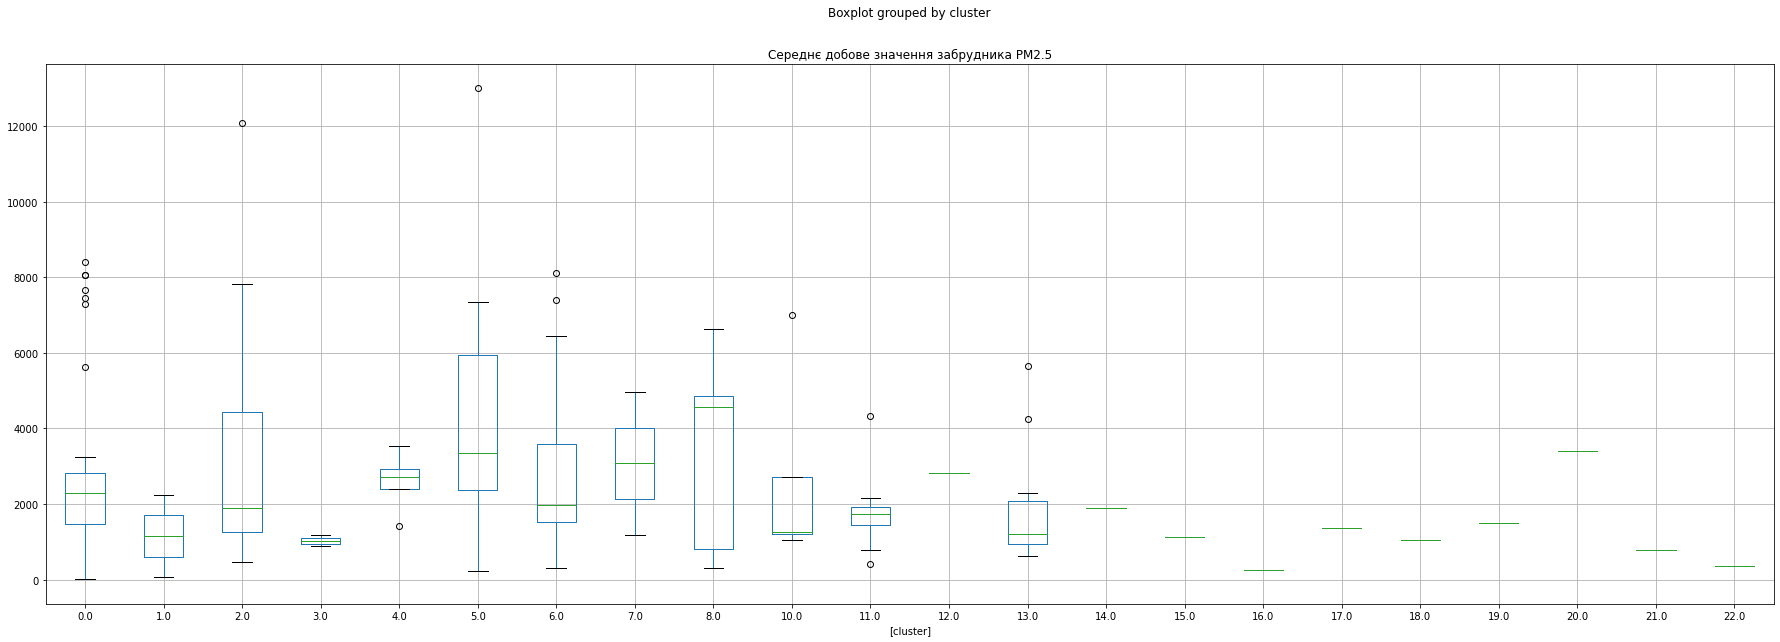

In [112]:
boxplot_daily(coord_DBSCAN)

In [47]:
outliers_daily_DBSCAN = outliers_daily(coord_DBSCAN)
outliers_daily_DBSCAN

,device_id,value,cluster,bot_lim,top_lim
0,1061,5625.40500,0,-539.651250,4835.478750
1,3432,7441.99500,0,-539.651250,4835.478750
2,13141,8063.01500,0,-539.651250,4835.478750
3,13207,7296.28700,0,-539.651250,4835.478750
4,13208,7670.24145,0,-539.651250,4835.478750
5,13268,8055.74245,0,-539.651250,4835.478750
6,13703,8415.59300,0,-539.651250,4835.478750
7,1415,12098.46500,2,-3488.731250,9193.178750
8,3688,1405.39500,4,1587.817500,3714.387500
9,2792,13002.60500,5,-2984.212500,11279.807500


In [49]:
# 11 з 16 станцій-викидів перетинаються з результатами на кластерах kmeans
same_outliers(outliers_daily_kmeans, outliers_daily_DBSCAN)

[13208, 13703, 1415, 2867, 3514, 3688, 2792, 13759, 1072, 1208, 2878]

In [78]:
method = ['CAMS', 'k-means', 'DBSCAN']
clusters = [len(coord_CAMS.cluster.unique()), len(coord_kmeans.cluster.unique()), len(coord_DBSCAN.cluster.unique())]
outliers = [outliers_daily_CAMS.device_id.tolist(), outliers_daily_kmeans.device_id.tolist(), outliers_daily_DBSCAN.device_id.tolist()]
outliers_num = [len(i) for i in outliers]

pd.DataFrame({'method': method, 'clusters': clusters, 'outliers_num': outliers_num, 'outliers': outliers})


,method,clusters,outliers_num,outliers
0,CAMS,12,16,"[2867, 2878, 3514, 13853, 1415, 3432, 13141, 1..."
1,k-means,15,15,"[1041, 13208, 13703, 13853, 1415, 2867, 3514, ..."
2,DBSCAN,23,17,"[1061, 3432, 13141, 13207, 13208, 13268, 13703..."
